# Exploratory Data Analysis
#### Dataset - Yahoo Finance


In [37]:
# yahoo_data_extraction.py
import yfinance as yf
import pandas as pd
import datetime as dt
import logging

# --- Logging setup ---
logging.basicConfig(
    filename="etl_logs.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

# --- Configurable parameters ---
TICKERS = ["AAPL", "GOOGL", "MSFT", "AMZN"]
START_DATE = "2020-01-01"
END_DATE = dt.date.today().isoformat()

def fetch_stock_data(ticker):
    try:
        df = yf.download(ticker, start=START_DATE, end=END_DATE)
        if df.empty:
            logging.warning(f"{ticker}: No data fetched")
            return pd.DataFrame()
        df.reset_index(inplace=True)
        df["Ticker"] = ticker
        logging.info(f"{ticker}: fetched {len(df)} records")
        return df
    except Exception as e:
        logging.error(f"Error fetching {ticker}: {e}")
        return pd.DataFrame()

# --- Run batch extraction ---
data_frames = [fetch_stock_data(t) for t in TICKERS if not fetch_stock_data(t).empty]
all_data = pd.concat(data_frames, ignore_index=True)


/tmp/ipython-input-4051955584.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-4051955584.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-4051955584.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-4051955584.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-405195558

In [43]:
import pandas as pd

# Read the CSV with no header
raw = pd.read_csv("historical_stocks.csv", header=None)

# Row 0 = metric names, Row 1 = tickers
metrics = raw.iloc[0].fillna("Date").tolist()
tickers = raw.iloc[1].fillna("Date").tolist()

# Combine metric + ticker into a MultiIndex for columns
columns = pd.MultiIndex.from_arrays([tickers, metrics])

# Real data starts from row 2 onward
data = raw.iloc[2:].reset_index(drop=True)
data.columns = columns

# Fix the Date column
data[("Date", "Date")] = pd.to_datetime(data[("Date", "Date")], errors="coerce")

# Now flatten this wide format to long (ticker per row)
records = []
for ticker in tickers:
    if ticker == "Date":  # skip the date pseudo-column
        continue
    sub = data[[("Date", "Date"),
                (ticker, "Open"),
                (ticker, "High"),
                (ticker, "Low"),
                (ticker, "Close"),
                (ticker, "Volume")]].copy()
    sub.columns = ["Date", "Open", "High", "Low", "Close", "Volume"]
    sub["Ticker"] = ticker
    records.append(sub)

clean_df = pd.concat(records, ignore_index=True)
clean_df = clean_df.dropna(subset=["Date"])  # drop any blank rows

# Save the tidy version
clean_df.to_csv("historical_stocks_clean.csv", index=False)
print("✅ Cleaned data saved to historical_stocks_clean.csv")
clean_df.head()


✅ Cleaned data saved to historical_stocks_clean.csv


,Date,Open,High,Low,Close,Volume,Ticker
0,2020-01-02,71.54587474672552,72.59887623049032,71.29228881100529,72.53849792480469,135480400.0,AAPL
1,2020-01-03,71.76568192376371,72.594070846621,71.6086997390569,71.83330535888672,146322800.0,AAPL
2,2020-01-06,70.95418053006813,72.4443131708714,70.70300468370534,72.40567016601562,118387200.0,AAPL
3,2020-01-07,72.41532188246822,72.67132530208438,71.84535422985819,72.06513214111328,108872000.0,AAPL
4,2020-01-08,71.76807129058055,73.5262872851597,71.76807129058055,73.22439575195312,132079200.0,AAPL


In [44]:
df = clean_df

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df["Date"] = pd.to_datetime(df["Date"])

# --- Basic overview ---
df.head()



,Date,Open,High,Low,Close,Volume,Ticker
0,2020-01-02,71.54587474672552,72.59887623049032,71.29228881100529,72.53849792480469,135480400.0,AAPL
1,2020-01-03,71.76568192376371,72.594070846621,71.6086997390569,71.83330535888672,146322800.0,AAPL
2,2020-01-06,70.95418053006813,72.4443131708714,70.70300468370534,72.40567016601562,118387200.0,AAPL
3,2020-01-07,72.41532188246822,72.67132530208438,71.84535422985819,72.06513214111328,108872000.0,AAPL
4,2020-01-08,71.76807129058055,73.5262872851597,71.76807129058055,73.22439575195312,132079200.0,AAPL


In [46]:
df.describe()

,Date
count,117760
mean,2022-12-04 11:54:07.826087168
min,2020-01-02 00:00:00
25%,2021-06-17 18:00:00
50%,2022-12-01 12:00:00
75%,2024-05-21 06:00:00
max,2025-11-07 00:00:00


In [47]:
df.isnull().sum()

,0
Date,0
Open,88320
High,88320
Low,88320
Close,88320
Volume,88320
Ticker,0


In [48]:
df.Ticker.value_counts()

,count
Ticker,
AAPL,29440
GOOGL,29440
MSFT,29440
AMZN,29440


In [52]:
print(df["Ticker"].unique())


['AAPL' 'GOOGL' 'MSFT' 'AMZN']


In [54]:

print(df["Close"].isna().sum())


88320


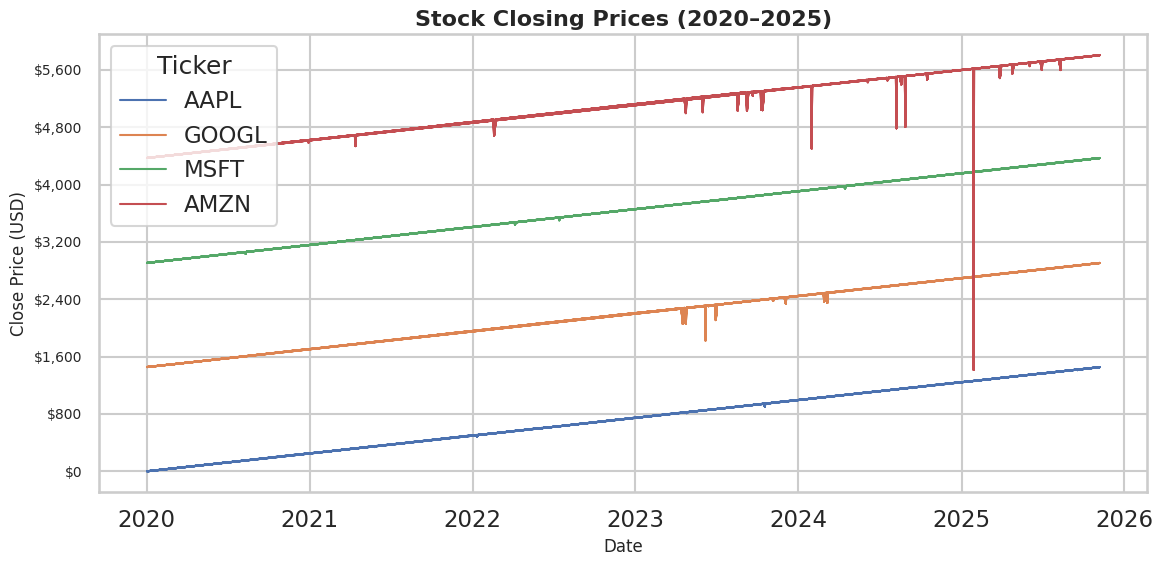

In [56]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(12,6))

for t in df["Ticker"].unique():
    subset = df[df["Ticker"] == t].dropna(subset=["Close"])
    plt.plot(subset["Date"], subset["Close"], label=t, linewidth=1.5)

# Titles and labels
plt.title("Stock Closing Prices (2020–2025)", fontsize=16, weight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price (USD)", fontsize=12)

# Clean up y-axis
ax = plt.gca()
ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=8))  # limit number of ticks
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("${x:,.0f}"))  # e.g. $100, $200 …
plt.tick_params(axis='y', labelsize=10, rotation=0)

# Legend and layout
plt.legend(title="Ticker", loc="upper left", frameon=True)
plt.tight_layout()
plt.show()


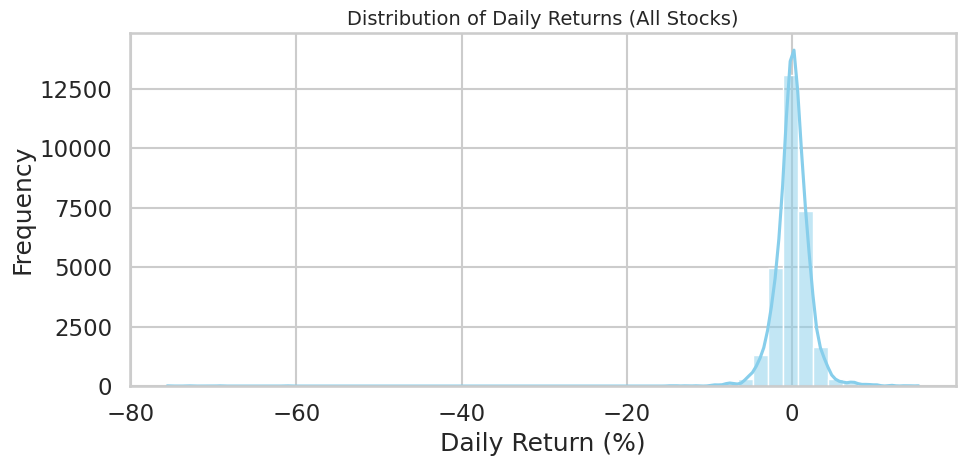

Volatility (%):
 Ticker
GOOGL    2.702359
AMZN     2.675902
AAPL     2.644285
MSFT     2.474219
Name: Daily_Return, dtype: float64


In [59]:
# Calculate daily percentage returns
# Force numeric types across all relevant columns
for col in ["Open", "High", "Low", "Close", "Volume"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop rows with missing Close after coercion
df = df.dropna(subset=["Close"])

df["Daily_Return"] = df.dropna(subset=["Close"]).groupby("Ticker")["Close"].pct_change() * 100

plt.figure(figsize=(10,5))
sns.histplot(df["Daily_Return"].dropna(), kde=True, bins=50, color="skyblue")
plt.title("Distribution of Daily Returns (All Stocks)", fontsize=14)
plt.xlabel("Daily Return (%)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Volatility (standard deviation of returns)
volatility = df.groupby("Ticker")["Daily_Return"].std().sort_values(ascending=False)
print("Volatility (%):\n", volatility)



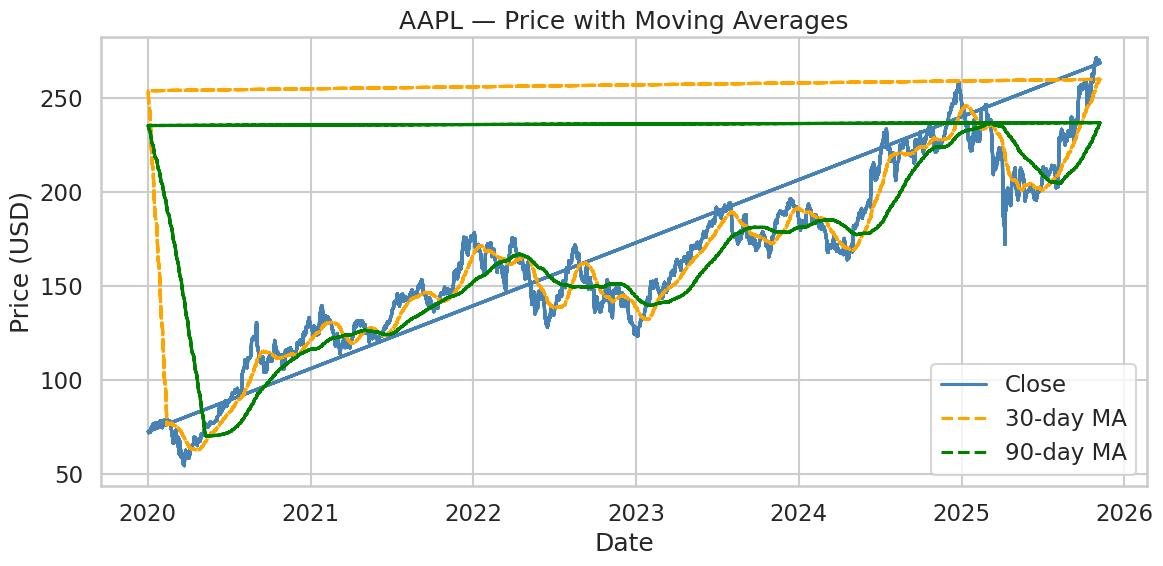

In [60]:
plt.figure(figsize=(12,6))
ticker = "AAPL"  # example
subset = df[df["Ticker"] == ticker].copy()
subset["MA30"] = subset["Close"].rolling(30).mean()
subset["MA90"] = subset["Close"].rolling(90).mean()

plt.plot(subset["Date"], subset["Close"], label="Close", color="steelblue")
plt.plot(subset["Date"], subset["MA30"], label="30-day MA", linestyle="--", color="orange")
plt.plot(subset["Date"], subset["MA90"], label="90-day MA", linestyle="--", color="green")
plt.title(f"{ticker} — Price with Moving Averages")
plt.xlabel("Date"); plt.ylabel("Price (USD)")
plt.legend(); plt.tight_layout()
plt.show()


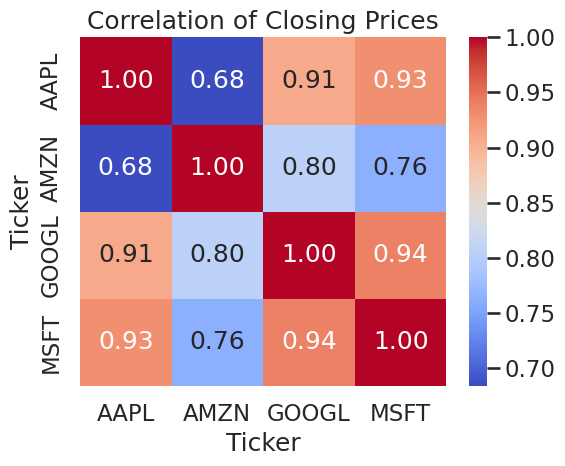

In [62]:
# Collapse any duplicates by taking the last Close per Date–Ticker pair
df_unique = df.groupby(["Date", "Ticker"], as_index=False)["Close"].last()

pivot = df_unique.pivot(index="Date", columns="Ticker", values="Close")

plt.figure(figsize=(6,5))
sns.heatmap(pivot.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of Closing Prices")
plt.tight_layout()
plt.show()
